In [1]:
import sys

import tensorflow.keras
import pandas as pd
import numpy as np
import sklearn as sk
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import platform
from sklearn.model_selection import train_test_split
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt


print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")


/var/folders/nc/qvnyyrpd0bs8ck8vt79yvt080000gn/T/ipykernel_8143/1939897653.py:12: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


Python Platform: macOS-13.4-arm64-arm-64bit
Tensor Flow Version: 2.9.0
Keras Version: 2.9.0

Python 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:26:08) [Clang 14.0.6 ]
Pandas 1.5.3
Scikit-Learn 1.2.2
GPU is available


In [4]:
#Load data
df = pd.read_csv('data_cleaned_R3.csv')

df.loc[df["Coal Input"] < 30] = 0

df = df.dropna()

#TODO Convert to a stats term?
df['Power Plant On'] = (df['Coal Input'] >= 30).astype(int)

inputs = df.iloc[:, :11].copy()

# Copy the next 5 rows into outputs
outputs = df.iloc[:, 11:16].copy()

off_index = df.iloc[:, 16].copy()


In [5]:
def create_3d_array(dataframe, time_window):
    # Create a new 3-dimensional array with the same dimensions as the dataframe
    array_3d = np.zeros((dataframe.shape[0], dataframe.shape[1], time_window))
    
    # Iterate over each column in the dataframe
    for col_idx, col in enumerate(dataframe.columns):
        # Get the values of the current column
        current_col = dataframe[col].values
        
        # Iterate over each time step
        for t in range(time_window):
            # Create a shifted version of the column
            shifted_col = np.roll(current_col, t) if t < len(current_col) else np.nan
            
            # Assign the shifted column values to the corresponding positions in the 3D array
            array_3d[:, col_idx, t] = shifted_col
    
    return array_3d

In [6]:
outputs_3d = create_3d_array(outputs, 2)
inputs_3d = create_3d_array(inputs, 5)
print(inputs_3d.shape)
print("inputs_3d.shape")
print(outputs_3d.shape)
print("outputs_3d.shape")

In [19]:
# Filter out when the plant is off.
mask  = off_index[:] != 0
print(mask)
on_inputs = inputs_3d[mask]
on_outputs = outputs_3d[mask]
print("on_inputs.shape")
print(on_inputs.shape)
print("on_outputs.shape")
print(on_outputs.shape)


0        False
1        False
2        False
3        False
4        False
         ...  
32763    False
32764    False
32765    False
32766    False
32767    False
Name: Power Plant On, Length: 32768, dtype: bool
on_inputs.shape
(22565, 11, 5)
on_outputs.shape
(22565, 5, 2)


In [28]:
#add zeros to the output array before the scaling
padded_array = np.pad(on_outputs, ((0,0),(0,6),(0,3)), 'constant')
print("padded_array.shape")
print(padded_array.shape)


padded_array.shape
(22565, 11, 5)


In [37]:
#Scale the data

scaler = MinMaxScaler()
reshaped_inputs = on_inputs.reshape(-1, on_inputs.shape[-1])

scaler.fit(reshaped_inputs)
scaled_inputs = scaler.transform(reshaped_inputs)
scaled_inputs = scaled_inputs.reshape(on_inputs.shape)
print("scaled_inputs.shape")
print(scaled_inputs.shape)

reshaped_padded_array = padded_array.reshape(-1, padded_array.shape[-1])
scaled_outputs = scaler.transform(reshaped_padded_array)
scaled_outputs = scaled_outputs.reshape(padded_array.shape)
print("scaled_outputs.shape")
print(scaled_outputs.shape)

scaled_outputs = scaled_outputs[:on_outputs.shape[0], :on_outputs.shape[1], :on_outputs.shape[2]]


scaled_inputs.shape
(22565, 11, 5)
scaled_outputs.shape
(22565, 11, 5)


In [38]:

# Remove the added dimensions
scaled_outputs = scaled_outputs[:on_outputs.shape[0], :on_outputs.shape[1], :on_outputs.shape[2]]

# Remove the padded zeros
#scaled_outputs = np.trim_zeros(scaled_outputs, 'b')


print("scaled_outputs.shape")
print(scaled_outputs.shape)

scaled_outputs.shape
(22565, 5, 2)


In [40]:
#Split data into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(scaled_inputs, scaled_outputs, test_size=0.1, shuffle=False)
print("X_train.shape")
print(X_train.shape)
print("X_test.shape")
print(X_test.shape)
print("Y_train.shape")
print(Y_train.shape)    
print("Y_test.shape")

X_train.shape
(20308, 11, 5)
X_test.shape
(2257, 11, 5)
Y_train.shape
(20308, 5, 2)
Y_test.shape


In [55]:
#RNN Code
class RNNModel:
    def __init__(self):
        self.n_hidden_units_per_layer = None
        self.learning_rate = None
        self.eta = None
        self.loss = None
        self.metrics = None
        self.epochs = None
        self.batch_size = None
        self.decay_rate = None
        self.n_encoder_depth = None
        self.n_decoder_depth = None
        self.n_int_layer_depth = None
        self.model = None
        self.history = None

    def set_hyperparameters(self, n_hidden_units_per_layer, learning_rate, eta, loss, metrics, epochs, batch_size,
                            decay_rate, n_encoder_depth, n_decoder_depth, n_int_layer_depth):
        self.n_hidden_units_per_layer = n_hidden_units_per_layer
        self.learning_rate = learning_rate
        self.eta = eta
        self.loss = loss
        self.metrics = metrics
        self.epochs = epochs
        self.batch_size = batch_size
        self.decay_rate = decay_rate
        self.n_encoder_depth = n_encoder_depth
        self.n_decoder_depth = n_decoder_depth
        self.n_int_layer_depth = n_int_layer_depth

    def build_model(self, X_shape, Y_shape):
        encoder_inputs = keras.layers.Input(shape=(None, X_shape[2]))
        encoder = keras.layers.GRU(self.n_hidden_units_per_layer, return_state=True,
                                    activation='relu',
                                    kernel_initializer=keras.initializers.glorot_normal(seed=2),
                                    activity_regularizer=keras.regularizers.l2(self.eta))
        encoder_outputs, state_h = encoder(encoder_inputs)
        encoder_states = [state_h]

        decoder_inputs = keras.layers.Input(shape=(None, Y_shape[2]))
        decoder_gru = keras.layers.GRU(self.n_hidden_units_per_layer, return_sequences=True,
                                         return_state=True, activation='relu',
                                         kernel_initializer=keras.initializers.glorot_normal(seed=2),
                                         activity_regularizer=keras.regularizers.l2(self.eta))
        decoder_outputs, _ = decoder_gru(decoder_inputs, initial_state=encoder_states)
        decoder_dense = keras.layers.TimeDistributed(keras.layers.Dense(Y_shape[2],
                                                                         kernel_initializer=keras.initializers.glorot_normal(
                                                                             seed=2),
                                                                         activity_regularizer=keras.regularizers.l2(
                                                                             self.eta)))
        decoder_outputs = decoder_dense(decoder_outputs)

        self.model = keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)

    def compile_model(self):
        optimizer = keras.optimizers.Adam(lr=self.learning_rate, beta_1=0.9, beta_2=0.999,
                                          epsilon=1E-8, decay=self.decay_rate)
        self.model.compile(loss=self.loss, optimizer=optimizer, metrics=[self.metrics])

    def train(self, X, Y):
        self.history = self.model.fit([X, Y], Y, epochs=self.epochs, batch_size=self.batch_size,
                                        validation_split=0.2,
                                        shuffle=False)

    def get_model(self):
        return self.model

    def get_history(self):
        return self.history

In [56]:
model = RNNModel()
model.set_hyperparameters(n_hidden_units_per_layer=10, learning_rate=0.001, eta=1E-8, loss='mean_squared_error',
                          metrics=['mae', tf.keras.metrics.MeanAbsolutePercentageError(name="mape"), tf.keras.metrics.RootMeanSquaredError(name="rmse")],
                            epochs=50, batch_size=64, decay_rate=1E-6, n_encoder_depth=1,
                          n_decoder_depth=1, n_int_layer_depth=1)
model.build_model(X_train.shape, Y_train.shape)
model.compile_model()
model.train(X_train, Y_train)
trained_model = model.get_model()
history = model.get_history()

Epoch 1/50


/Users/calvindurr/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2023-06-11 20:00:52.719503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


254/254 [==============================] - ETA: 0s - loss: 0.0937 - mae: 0.2138 - mape: 357.9014 - rmse: 0.3060

2023-06-11 20:01:32.622762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


254/254 [==============================] - 43s 161ms/step - loss: 0.0937 - mae: 0.2138 - mape: 357.9014 - rmse: 0.3060 - val_loss: 0.0098 - val_mae: 0.0863 - val_mape: 166.4423 - val_rmse: 0.0990
Epoch 2/50
254/254 [==============================] - 39s 155ms/step - loss: 0.0041 - mae: 0.0481 - mape: 134.3855 - rmse: 0.0641 - val_loss: 8.8802e-04 - val_mae: 0.0210 - val_mape: 27.9976 - val_rmse: 0.0298
Epoch 3/50
254/254 [==============================] - 40s 157ms/step - loss: 5.7410e-04 - mae: 0.0151 - mape: 55.6979 - rmse: 0.0240 - val_loss: 1.7446e-04 - val_mae: 0.0092 - val_mape: 20.4120 - val_rmse: 0.0132
Epoch 4/50
254/254 [==============================] - 39s 155ms/step - loss: 2.3760e-04 - mae: 0.0091 - mape: 46.8902 - rmse: 0.0154 - val_loss: 9.9839e-05 - val_mae: 0.0070 - val_mape: 17.1080 - val_rmse: 0.0100
Epoch 5/50
254/254 [==============================] - 40s 156ms/step - loss: 1.7528e-04 - mae: 0.0074 - mape: 43.7856 - rmse: 0.0132 - val_loss: 7.8261e-05 - val_mae: 0

In [57]:
# Evaluate the model on the test set
test_loss = trained_model.evaluate([X_test, Y_test], Y_test)

71/71 [==============================] - 17s 168ms/step - loss: 2.7580e-06 - mae: 0.0012 - mape: 5.0414 - rmse: 0.0016


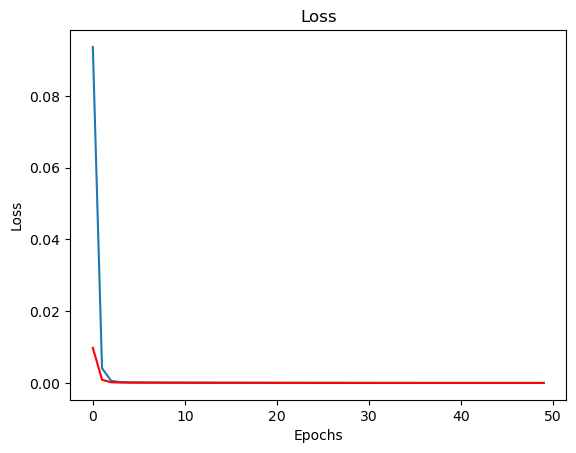

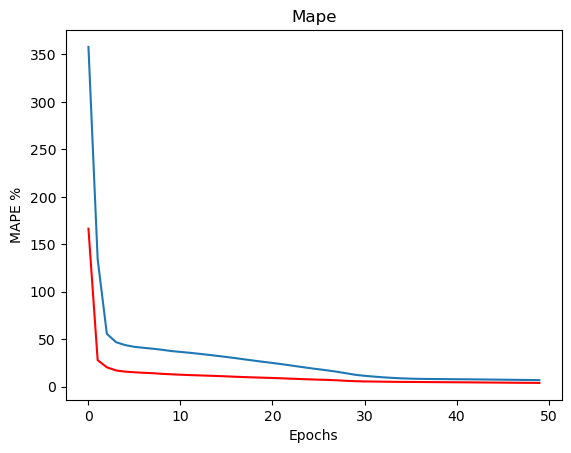

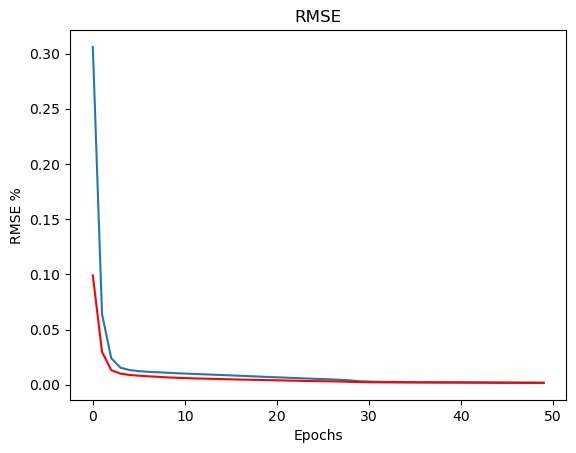

In [59]:
    # Plot the training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], color="red")
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'], color="red")
plt.title('Mape')
plt.xlabel('Epochs')
plt.ylabel('MAPE %')
plt.show()

plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'], color="red")
plt.title('RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE %')
plt.show()